# 넷플릭스 추천 시스템 알고리즘


휴스타 1기 ICT 특화 트랙에서 김영섭 교수님의 AI수업 프로젝트의 일환으로 하게된 프로젝트입니다.
이 노트는 아래 링크를 번역하고 수정하여 작성되었습니다.

https://www.kaggle.com/laowingkin/netflix-movie-recommendation 

Data set은
https://www.kaggle.com/netflix-inc/netflix-prize-data
에서 받을 수 있습니다.


---------------------------

이 프로젝트는 넷플릭스의 영화 추천 매커니즘을 만드는 것을 목표로 진행되었습니다.
넷플릭스가 Kaggle에 올린 dataset을 사용했고 여기엔 각각 약 4천개의 영화와 40만의 고객이 포함된 2000만개의 행을 가진 4개의 text data file이 있습니다. 따라서 모두 합하면 1만7천개의 영화와 50만이 넘는 고객의 리스트가 포함되어 있습니다.

약 2기가 쯤 되는 데이터를 커널에 로드하는 것부터 굉장한 도전이 됩니다. 따라서 원글의 작성자는 효율적인 데이터 접근을 하기위해 많은 노력을 했고 이는 코드에 나타나고 있습니다.


-------------------------------

# 환경 설정
----------------------
먼저 이 프로젝트를 실행하기 위해 여러 파이썬 라이브러리가 설치되어야 합니다.
밑의 import부분을 실행하여 부족한 라이브러리를 설치하세요.

In [ ]:
#pip install pandas
#pip install numpy
#pip install scikit-surprise

In [2]:
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns 
from surprise import Reader, Dataset, SVD, model_selection
sns.set_style("darkgrid")

In [ ]:
##################################
# 원글의 코드 입니다. 
# surprise 모듈의 evaluate가 버전 업데이트로 없어지고
# model_selection의 한 부분으로 들어가 evaluate대신 model_selection을 import합니다.
##################################
#import pandas as pd
#import numpy as np
#import math
#import re
#from scipy.sparse import csr_matrix
#import matplotlib.pyplot as plt
#import seaborn as sns
#from surprise import Reader, Dataset, SVD, evaluate
#sns.set_style("darkgrid")

## 데이터 불러오기

--------------------------------------------
4개의 data file에는 아래와 같은 column을 갖고있습니다.
- Movie ID
- Customer ID
- Rating (1 to 5)
- Date they gave the ratings


그리고 다른 파일엔 Movie ID와 각 영화의 background를 mapping할 수 있는 정보를 갖고 있습니다. (ex. name, year of release, etc)

-----------------------------
그럼 먼저 커다란 파일 한개만 우선 읽어보도록 하겠습니다.

(필요한 경우 read_csv의 파일 경로를 수정하기 바랍니다.)

In [3]:
# Skip date
df1 = pd.read_csv('data/combined_data_1.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])

df1['Rating'] = df1['Rating'].astype(float)

print('Dataset 1 shape: {}'.format(df1.shape))
print('-Dataset examples-')
print(df1.iloc[::5000000, :])

Dataset 1 shape: (24058263, 2)
-Dataset examples-
          Cust_Id  Rating
0              1:     NaN
5000000   2560324     4.0
10000000  2271935     2.0
15000000  1921803     2.0
20000000  1933327     3.0


파일 하나에 약 2400만개의 행이 있는걸 확인할 수 있습니다.
밑의 코드는 나머지 데이터 파일을 불러오는 코드입니다.
하지만 크기가 매우 크니 먼저 파일 한개로 끝까지 실행해 보시고 충분한 시간과 충분한 성능의 PC가 있을 때 실행해 보시기 바랍니다.

In [ ]:
#df2 = pd.read_csv('data/combined_data_2.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
#df3 = pd.read_csv('data/combined_data_3.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
#df4 = pd.read_csv('data/combined_data_4.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])


#df2['Rating'] = df2['Rating'].astype(float)
#df3['Rating'] = df3['Rating'].astype(float)
#df4['Rating'] = df4['Rating'].astype(float)

#print('Dataset 2 shape: {}'.format(df2.shape))
#print('Dataset 3 shape: {}'.format(df3.shape))
#print('Dataset 4 shape: {}'.format(df4.shape))

# 데이터 합치기
----------------------------------
만약 위에서 4개의 파일을 모두 불러왔다면 이를 합쳐야합니다.
주석처리된 부분을 수정하고 실행하세요.

In [4]:
df = df1
#df = df1.append(df2)
#df = df.append(df3)
#df = df.append(df4)

df.index = np.arange(0,len(df))
print('Full dataset shape: {}'.format(df.shape))
print('-Dataset examples-')
print(df.iloc[::5000000, :])

Full dataset shape: (24058263, 2)
-Dataset examples-
          Cust_Id  Rating
0              1:     NaN
5000000   2560324     4.0
10000000  2271935     2.0
15000000  1921803     2.0
20000000  1933327     3.0


# 데이터 보기
---------------------
이제 데이터가 어떻게 분포되어 있는지 확인해보겠습니다.

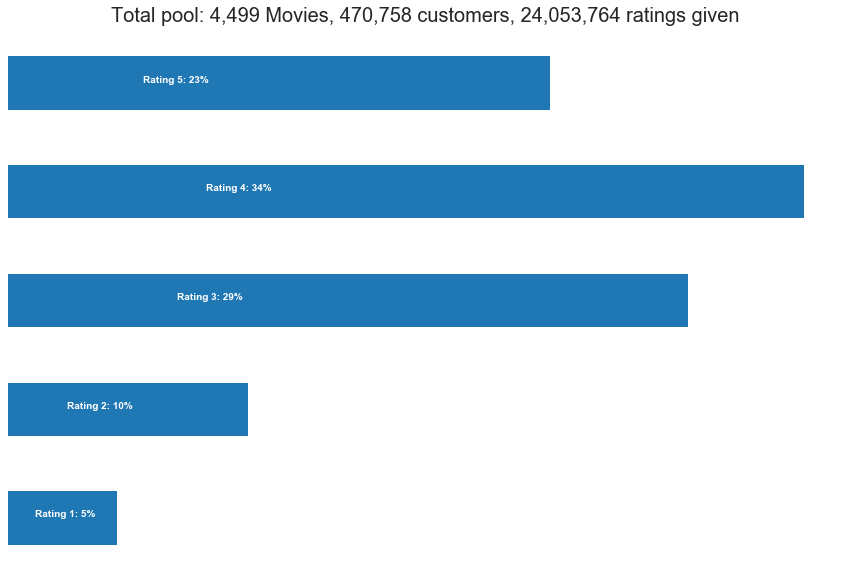

In [5]:
p = df.groupby('Rating')['Rating'].agg(['count'])

# get movie count
movie_count = df.isnull().sum()[1]

# get customer count
cust_count = df['Cust_Id'].nunique() - movie_count

# get rating count
rating_count = df['Cust_Id'].count() - movie_count

ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total pool: {:,} Movies, {:,} customers, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')

대부분의 리뷰가 3점 이상에 분포하고 있는걸 확인할 수 있습니다.

이는 만족하지 않은 고객들이 rating 하는 것을 원하지 않아 바로 떠나는 경향을 보이기 때문에 그럴수 있다고 원글의 저자는 설명합니다. (따라서 low rating movie는 일반적으로 굉장히 나쁩니다...)

# 데이터 정리 (Data cleaning)
------------------------------
Movie ID를 처리하기 위해 전체 데이터를 loop로 돌리기엔 비효율적이기 때문에 numpy array를 각 영화의 rating 길이 만큼 만든 다음 movie를 추가하여 데이터에 붙이겠습니다.


In [6]:
df_nan = pd.DataFrame(pd.isnull(df.Rating))
df_nan = df_nan[df_nan['Rating'] == True]
df_nan = df_nan.reset_index()

movie_np = []
movie_id = 1

for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    # numpy approach
    temp = np.full((1,i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1

# Account for last record and corresponding length
# numpy approach
last_record = np.full((1,len(df) - df_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record)

print('Movie numpy: {}'.format(movie_np))
print('Length: {}'.format(len(movie_np)))

Movie numpy: [1.000e+00 1.000e+00 1.000e+00 ... 4.499e+03 4.499e+03 4.499e+03]
Length: 24053764


In [7]:
# remove those Movie ID rows
# 오류가 나지만 일단 실행되니 넘어갑니다......
df = df[pd.notnull(df['Rating'])]

df['Movie_Id'] = movie_np.astype(int)
df['Cust_Id'] = df['Cust_Id'].astype(int)
print('-Dataset examples-')
print(df.loc[::5000000, :])

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


-Dataset examples-
          Cust_Id  Rating  Movie_Id
1         1488844     3.0         1
5000996    501954     2.0       996
10001962   404654     5.0      1962
15002876   886608     2.0      2876
20003825  1193835     2.0      3825


C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


# 데이터 자르기(Data slicing)
------------------------------
이제 data set이 아주 커졌습니다. 다양한 방법으로 시도했지만 메모리 에러 없이 실행하는 것은 불가능했습니다. 따라서 데이터의 질을 높이는 방향으로 데이터의 크기를 줄이고자 아래에 해당되는 데이터를 삭제했습니다.

- 리뷰의 개수가 너무 적은 영화 (상대적으로 유명하지 않음)
- 너무 적은 리뷰를 적은 고객 (상대적으로 활동적이지 않음)

In [8]:
f = ['count','mean']

df_movie_summary = df.groupby('Movie_Id')['Rating'].agg(f)
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(0.7),0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index

print('Movie minimum times of review: {}'.format(movie_benchmark))

df_cust_summary = df.groupby('Cust_Id')['Rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.7),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Customer minimum times of review: {}'.format(cust_benchmark))

Movie minimum times of review: 1799.0
Customer minimum times of review: 52.0


In [9]:
print('Original Shape: {}'.format(df.shape))
df = df[~df['Movie_Id'].isin(drop_movie_list)]
df = df[~df['Cust_Id'].isin(drop_cust_list)]
print('After Trim Shape: {}'.format(df.shape))
print('-Data Examples-')
print(df.iloc[::5000000, :])


Original Shape: (24053764, 3)
After Trim Shape: (17337458, 3)
-Data Examples-
          Cust_Id  Rating  Movie_Id
696        712664     5.0         3
6932490   1299309     5.0      1384
13860273   400155     3.0      2660
20766530   466962     4.0      3923


이제 추천시스템을 위해 데이터를 커다란 matrix에 넣겠습니다.

In [10]:
df_p = pd.pivot_table(df,values='Rating',index='Cust_Id',columns='Movie_Id')

print(df_p.shape)

# Below is another way I used to sparse the dataframe...doesn't seem to work better
# 아래 코드는 다른 방식으로 시도한 코드지만 잘 되는 것 같진 않습니다.

#Cust_Id_u = list(sorted(df['Cust_Id'].unique()))
#Movie_Id_u = list(sorted(df['Movie_Id'].unique()))
#data = df['Rating'].tolist()
#row = df['Cust_Id'].astype('category', categories=Cust_Id_u).cat.codes
#col = df['Movie_Id'].astype('category', categories=Movie_Id_u).cat.codes
#sparse_matrix = csr_matrix((data, (row, col)), shape=(len(Cust_Id_u), len(Movie_Id_u)))
#df_p = pd.DataFrame(sparse_matrix.todense(), index=Cust_Id_u, columns=Movie_Id_u)
#df_p = df_p.replace(0, np.NaN)

(143458, 1350)


# 데이터 맵핑
-----------------------------
이제 movie mapping file을 불러오겠습니다.

In [11]:
df_title = pd.read_csv('data/movie_titles.csv', encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'])
df_title.set_index('Movie_Id', inplace = True)
print (df_title.head(10))

            Year                          Name
Movie_Id                                      
1         2003.0               Dinosaur Planet
2         2004.0    Isle of Man TT 2004 Review
3         1997.0                     Character
4         1994.0  Paula Abdul's Get Up & Dance
5         2004.0      The Rise and Fall of ECW
6         1997.0                          Sick
7         1992.0                         8 Man
8         2004.0    What the #$*! Do We Know!?
9         1991.0      Class of Nuke 'Em High 2
10        2001.0                       Fighter


# 추천 모델 (Recommendation models)
------------------------------------
이제 추천 모델에 데이터를 넣어보겠습니다.!

### Recommend with Collaborative Filtering
----------------------------------------
 collaborative filtering을 이용하겠습니다. 
 Collaborative Filtering은 사용자의 평점 행렬이 가지고 있는 특별한 패턴을 찾아 예측하는 방법입니다. 여기엔 사용자나 상품 기준으로 평점의 유사성을 살피는 Neighborhood 모형과 행렬의 수치적 특징을 이용하는 Latent Factor 모형이 있습니다. 이 프로젝트에선 LF 모형을 사용한 것 같습니다.
 
 (알고리즘 설명 : https://datascienceschool.net/view-notebook/fcd3550f11ac4537acec8d18136f2066/)
 
 
 빠른 처리를 위해 10만개의 행만 실행하겠습니다.

In [12]:
reader = Reader()

# get just top 100K rows for faster run time
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']][:100000], reader)
#data.split(n_folds=3)  #에러 떠서 주석처리함 에러 검색해도 안나옴 노답


svd = SVD()
model_selection.validation.cross_validate(svd, data, measures=['RMSE', 'MAE'])

{'test_rmse': array([0.99656971, 1.0012602 , 0.99156424, 0.99712084, 0.99526986]),
 'test_mae': array([0.79601922, 0.80946127, 0.79886149, 0.80465543, 0.79181407]),
 'fit_time': (3.652230739593506,
  3.3639724254608154,
  3.3630034923553467,
  3.400874137878418,
  3.3563289642333984),
 'test_time': (0.08275079727172852,
  0.12668776512145996,
  0.08180928230285645,
  0.12668871879577637,
  0.08280587196350098)}

밑의 코드는 사용자 783514가 이전에 좋아한 영화 리스트입니다.

In [13]:
df_785314 = df[(df['Cust_Id'] == 785314) & (df['Rating'] == 5)]
df_785314 = df_785314.set_index('Movie_Id')
df_785314 = df_785314.join(df_title)['Name']
print(df_785314)

Movie_Id
57                                            Richard III
175                                        Reservoir Dogs
311                                               Ed Wood
329                                                 Dogma
331                                           Chasing Amy
395                                         Captain Blood
788                                                Clerks
798                                                  Jaws
907                                       Animal Crackers
985                                             The Mummy
1552                                          Black Adder
1905    Pirates of the Caribbean: The Curse of the Bla...
2000                          Four Weddings and a Funeral
2122                                 Being John Malkovich
2342                                        Super Size Me
2360                                  Singin' in the Rain
2430                           Alien: Collector's Edition
2443 

이제 사용자 785314가 좋아할 영화를 예측해보겠습니다.

In [14]:
user_785314 = df_title.copy()
user_785314 = user_785314.reset_index()
user_785314 = user_785314[~user_785314['Movie_Id'].isin(drop_movie_list)]

# getting full dataset
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']], reader)

trainset = data.build_full_trainset()
svd.fit(trainset)

user_785314['Estimate_Score'] = user_785314['Movie_Id'].apply(lambda x: svd.predict(785314, x).est)

user_785314 = user_785314.drop('Movie_Id', axis = 1)

user_785314 = user_785314.sort_values('Estimate_Score', ascending=False)
print(user_785314.head(10))

        Year                                           Name  Estimate_Score
787   1994.0                                         Clerks        4.993447
2113  2002.0                                        Firefly        4.952176
3520  2000.0                             Coupling: Season 1        4.902880
4391  1993.0                               Army of Darkness        4.886099
67    2004.0                                    Invader Zim        4.855995
3167  1987.0                      Evil Dead 2: Dead by Dawn        4.778670
328   1999.0                                          Dogma        4.752497
2531  1999.0                               Futurama: Vol. 1        4.749003
2056  2001.0             Buffy the Vampire Slayer: Season 6        4.741311
315   1999.0  Futurama: Monster Robot Maniac Fun Collection        4.731817


## Recommend with Pearsons' R correlations
-------------------------------
이제 Pearson의 R correlation을 이용하여 추천 모델을 만들겠습니다.
모든 영화와 리뷰 점수 간의 선형 관계를 측정하고 가장 높은 상관 관계를 갖는 상위 10개의 영화를 제공하는 방식입니다.

In [23]:
def recommend(movie_title, min_count):
    print("For movie ({})".format(movie_title))
    print("- Top 10 movies recommended based on Pearsons'R correlation - ")
    i = int(df_title.index[df_title['Name'] == movie_title][0])
    target = df_p[i]
    similar_to_target = df_p.corrwith(target)
    corr_target = pd.DataFrame(similar_to_target, columns = ['PearsonR'])
    corr_target.dropna(inplace = True)
    corr_target = corr_target.sort_values('PearsonR', ascending = False)
    corr_target.index = corr_target.index.map(int)
    corr_target = corr_target.join(df_title).join(df_movie_summary)[['PearsonR', 'Name', 'count', 'mean']]
    print(corr_target[corr_target['count']>min_count][:10].to_string(index=False))

만약 사용자가 영화 "What the #$*! Do We Know!?"를 좋아한다면 아래의 영화를 추천하게 됩니다.

In [24]:
recommend("What the #$*! Do We Know!?", 0)

For movie (What the #$*! Do We Know!?)
- Top 10 movies recommended based on Pearsons'R correlation - 
 PearsonR                                      Name  count      mean
 1.000000                What the #$*! Do We Know!?  14910  3.189805
 0.505500                                 Inu-Yasha   1883  4.554434
 0.452807  Captain Pantoja and the Special Services   1801  3.417546
 0.442354                 Without a Trace: Season 1   2124  3.980226
 0.384179                      Yu-Gi-Oh!: The Movie   3173  3.331547
 0.383959                                  Scorched   2430  2.894239
 0.381173   All Creatures Great and Small: Series 1   2327  3.938118
 0.381112           As Time Goes By: Series 1 and 2   2249  4.164073
 0.373018                          Cowboys & Angels   2368  3.589527
 0.371981                            Biggie & Tupac   1866  3.019293


다음은 X2:X-Men을 좋아하는 추천자에게 뜨는 추천 목록입니다.

In [25]:
recommend("X2: X-Men United", 0)

For movie (X2: X-Men United)
- Top 10 movies recommended based on Pearsons'R correlation - 
 PearsonR                                               Name  count      mean
 1.000000                                   X2: X-Men United  98720  3.932202
 0.384550                           Batman Beyond: The Movie   2614  3.726855
 0.375967                                     Justice League   3591  3.710944
 0.361393                   Justice League: Justice on Trial   2961  3.718001
 0.338025                 Batman Beyond: Return of the Joker   3704  3.604752
 0.335256                                      Batman Begins  54922  4.236699
 0.328229                       Batman: Mask of the Phantasm   2823  3.767977
 0.327040  Batman: The Animated Series: Tales of the Dark...   2432  3.583059
 0.316666                    Dragon Ball Z: Super Android 13   2426  3.428689
 0.316166                           Mortal Kombat: The Movie   7633  3.165466
